# Bike-shareの需要予測
- 最終的に各時刻のcount・貸し出し数を予測する

### テーブル定義
| 用語         | 定義                                                     | 日本語訳                            |
|--------------|----------------------------------------------------------|-----------------------------------|
| datetime     | hourly date + timestamp                                  | 日時 - 毎時の日付とタイムスタンプ         |
| season       | 1 = spring, 2 = summer, 3 = fall, 4 = winter             | 季節 - 1 = 春、2 = 夏、3 = 秋、4 = 冬      |
| holiday      | whether the day is considered a holiday                  | 休日 - その日が休日かどうか                 |
| workingday   | whether the day is neither a weekend nor holiday        | 営業日 - その日が週末でも休日でもないかどうか |
| weather      | 1: Clear, Few clouds, Partly cloudy, Partly cloudy      | 天候 - 1: 晴れ、くもり少なし、ややくもり、ややくもり      |
|              | 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist | 天候 - 2: 霧 + 曇り、霧 + くもり、霧 + わずかな雲、霧 |
|              | 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds | 天候 - 3: 軽い雪、軽い雨 + 雷雨 + 散在する雲、軽い雨 + 散在する雲 |
|              | 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog | 天候 - 4: 大雨 + あられ + 雷雨 + 霧、雪 + 霧       |
| temp         | temperature in Celsius                                   | 気温 - 摂氏での気温                      |
| atemp        | "feels like" temperature in Celsius                       | 体感気温 - 摂氏での体感気温               |
| humidity     | relative humidity                                        | 湿度 - 相対湿度                        |
| windspeed    | wind speed                                               | 風速 - 風速                            |
| casual       | number of non-registered user rentals initiated          | キャジュアル - 非登録ユーザーによる貸出数   |
| registered   | number of registered user rentals initiated              | 登録ユーザー - 登録ユーザーによる貸出数    |
| count        | number of total rentals                                  | 合計数 - 全体の貸出数                   |


In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import missingno as msno
import matplotlib.pyplot as plt
import warnings
import japanize_matplotlib
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## 1. データの分布+前処理

In [4]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
display(train.head())
display(test.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### trainデータの統計情報
- windspeedとhumidityの最小値がなぜか0になっていて、非現実的な値になっている
    - 何かで置き換えが必要

In [7]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


In [9]:
numeric_cols = ['temp', 'atemp','humidity', 'windspeed']
category_cols = ['season', 'holiday', 'weather']
target = 'count'

### datetimeを分割する

In [10]:
def parse_datetime(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['day'] = df['datetime'].dt.day
    df['hour'] = df['datetime'].dt.hour
    df['week'] = df['datetime'].dt.isocalendar().week
    df['weekday'] = df['datetime'].dt.dayofweek

parse_datetime(train)
parse_datetime(test)
display(train.head())

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,52,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,52,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,52,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,52,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,52,5


In [20]:
print(train.shape)

(10886, 18)


/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/2095865713.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train[column], label="Train")
/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/2095865713.py:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test[colum

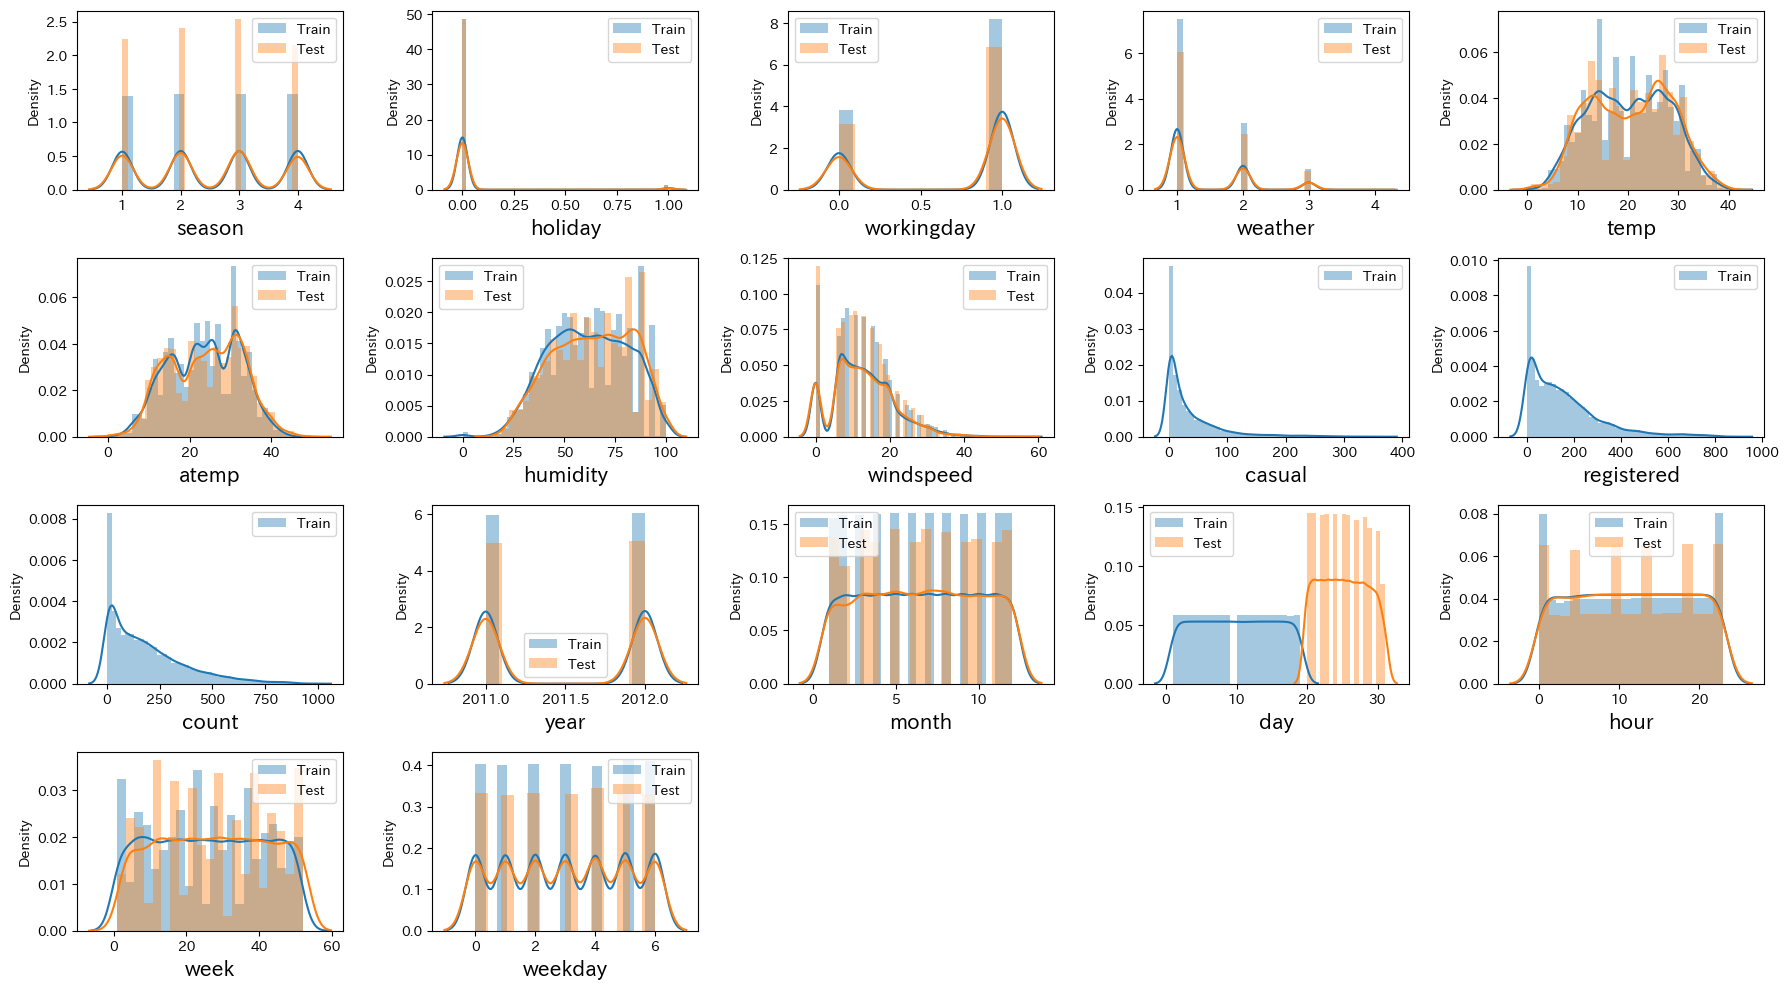

In [21]:
plt.figure(figsize = (18, 10))
plotnumber = 1

for column in train.columns:
    ax = plt.subplot(4, 5 , plotnumber)
    if column == "count" or column == "casual" or column == "registered":
        sns.distplot(train[column], label="Train")
    elif column == "datetime":
        continue
    else:
        sns.distplot(train[column], label="Train")
        sns.distplot(test[column], label="Test")
    plt.xlabel(column, fontsize = 15)
    plotnumber += 1
    plt.legend()
plt.tight_layout()
plt.show()

### 欠損値の確認
- 幸い、今回のtrainデータには、欠損値はなかった。

In [11]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
week          0
weekday       0
dtype: int64

### 外れ値の確認
以下の箱ひげ図からわかること
- countの異常値の分布は右側に偏ってる
- 中央値を見る限り、春は相対的に数が少ない
- 中央値は午前7時～8時と午後5時～6時に比較的高い
- 午前7時～8時と午後5時～6時の中央値が比較的高い
- ほとんどの異常値は、「非営業日」よりも「営業日」に寄与している

[Text(0.5, 0, 'Working Day'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, '営業日かどうかの分布')]

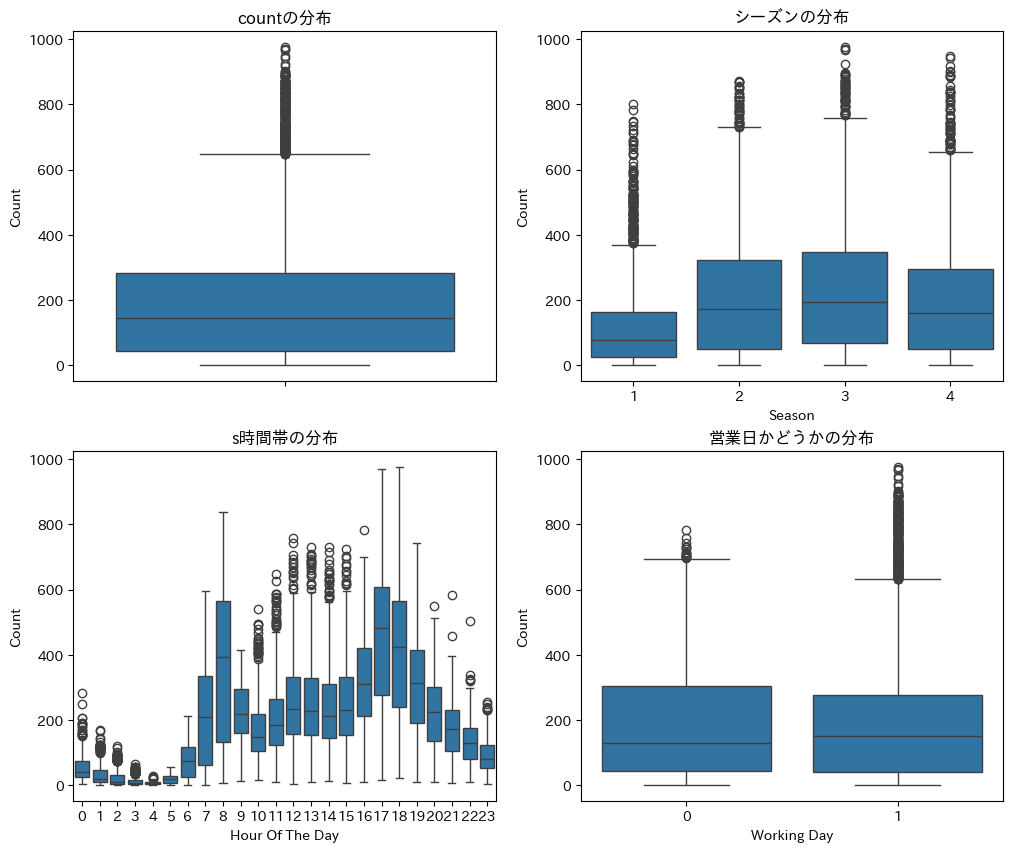

In [23]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12,10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="countの分布")
axes[0][1].set(xlabel='Season', ylabel='Count',title="シーズンの分布")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="s時間帯の分布")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="営業日かどうかの分布")

In [24]:
trainWithoutOutliers = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())]
print ("外れ値処理前: ",train.shape)
print ("外れ値処理後: ",trainWithoutOutliers.shape)

外れ値処理前:  (10886, 18)
外れ値処理後:  (10739, 18)


### windspeedとhumidityが0になっているところを別の値に置き換える
### 対処法
- windspeed
    - 全部で1313レコードあり、まばらに散在している
    - そのため、平均で補完するのは危ないので、正しく値が入ってるデータでwindspeedの値を予測するモデルを作成して、補完する
        - 前後の値を用いて、補完する方法もありではある
- humidity
    - 全て同じ日で起きているため、観測等のデータの記録ミスで生じてると考えられる
    - そして、その日はほぼweather=3（軽い雨）になっているため、軽い雨の平均をとって補完する

In [29]:
count_of_min_value = train[train['windspeed']==0].shape[0]

count_of_min_value

1313

In [30]:
min_value_rows = train[train['windspeed'] == 0]

display(min_value_rows.sample(10))

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
7865,2012-06-08 02:00:00,2,0,1,1,22.96,26.515,56,0.0,2,17,19,2012,6,8,2,23,4
3848,2011-09-11 08:00:00,3,0,0,1,26.24,29.545,78,0.0,25,69,94,2011,9,11,8,36,6
9085,2012-09-01 22:00:00,3,0,0,2,27.06,29.545,89,0.0,21,57,78,2012,9,1,22,35,5
322,2011-01-14 22:00:00,1,0,1,2,6.56,11.365,69,0.0,2,34,36,2011,1,14,22,2,4
10617,2012-12-08 19:00:00,4,0,0,1,16.40,20.455,87,0.0,34,212,246,2012,12,8,19,49,5
9972,2012-10-19 21:00:00,4,0,1,1,20.50,24.240,77,0.0,17,189,206,2012,10,19,21,42,4
6436,2012-03-05 10:00:00,1,0,1,2,9.84,12.880,60,0.0,12,74,86,2012,3,5,10,10,0
4710,2011-11-09 08:00:00,4,0,1,1,13.12,17.425,93,0.0,19,437,456,2011,11,9,8,45,2
10826,2012-12-17 12:00:00,4,0,1,2,16.40,20.455,87,0.0,21,211,232,2012,12,17,12,51,0
4224,2011-10-08 01:00:00,4,0,0,1,18.86,22.725,82,0.0,14,51,65,2011,10,8,1,40,5


In [37]:
from sklearn.ensemble import RandomForestClassifier

def wind_0_fill(df):
    wind_0 = df[df['windspeed']==0]
    wind_not0 = df[df['windspeed']!=0]
    y_label = wind_not0['windspeed']
    rfc = RandomForestClassifier(n_estimators=1000,max_depth=10,random_state=0)
    windcolunms = ['season', 'weather', 'temp', 'atemp', 'humidity', 'hour', 'month']
    rfc.fit(wind_not0[windcolunms], y_label.astype('int'))
    pred_y = rfc.predict(wind_0[windcolunms])
    wind_0['windspeed'] = pred_y

    df_rfw = pd.concat([wind_not0,wind_0],ignore_index=True)
    df_rfw.reset_index(inplace=True)
    df_rfw.drop('index',inplace=True,axis=1)
    return df_rfw

train = wind_0_fill(train)
test = wind_0_fill(test)

In [31]:
# train['windspeed'] = train['windspeed'].replace(0, method='ffill').replace(0, method='bfill')
# train['windspeed'].min()

/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/317092785.py:1: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  train['windspeed'] = train['windspeed'].replace(0, method='ffill').replace(0, method='bfill')


6.0032

In [28]:
count_of_min_value = train[train['humidity']==0].shape[0]

count_of_min_value

22

In [26]:
min_value_rows = train[train['humidity'] == 0]

min_value_rows

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
1091,2011-03-10 00:00:00,1,0,1,3,13.94,15.910,0,16.9979,3,0,3,2011,3,10,0,10,3
1092,2011-03-10 01:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,2,2,2011,3,10,1,10,3
1093,2011-03-10 02:00:00,1,0,1,3,13.94,15.910,0,16.9979,0,1,1,2011,3,10,2,10,3
1094,2011-03-10 05:00:00,1,0,1,3,14.76,17.425,0,12.9980,1,2,3,2011,3,10,5,10,3
1095,2011-03-10 06:00:00,1,0,1,3,14.76,16.665,0,22.0028,0,12,12,2011,3,10,6,10,3
1096,2011-03-10 07:00:00,1,0,1,3,15.58,19.695,0,15.0013,1,36,37,2011,3,10,7,10,3
1097,2011-03-10 08:00:00,1,0,1,3,15.58,19.695,0,19.0012,1,43,44,2011,3,10,8,10,3
1098,2011-03-10 09:00:00,1,0,1,3,16.40,20.455,0,15.0013,1,23,24,2011,3,10,9,10,3
1099,2011-03-10 10:00:00,1,0,1,3,16.40,20.455,0,11.0014,0,17,17,2011,3,10,10,10,3
1100,2011-03-10 11:00:00,1,0,1,3,16.40,20.455,0,16.9979,6,5,11,2011,3,10,11,10,3


In [32]:
rain_weather = train[train['weather'] == 3]
mean_rain_weather_humidity = rain_weather['humidity'].mean()
train['humidity'] = train['humidity'].replace(0, mean_rain_weather_humidity)
train['humidity'].min()

8.0

In [38]:
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,week,weekday
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.0,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,62.050845,13.968420,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,25.917784,3.013963
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,8.000000,6.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,1.0,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,8.000000,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,14.0,1.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,26.0,3.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,78.000000,19.000000,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,40.0,5.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,52.0,6.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.062226,7.018378,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,15.017269,2.004585


### 相関分析
- 下図からもわかるように、atempとtempの相関がほぼ1になっている
    - 気温と体感気温だからほぼ1にならないと逆におかしい
    - 多重共線性で学習時に影響がでないように、どちらかを削除する

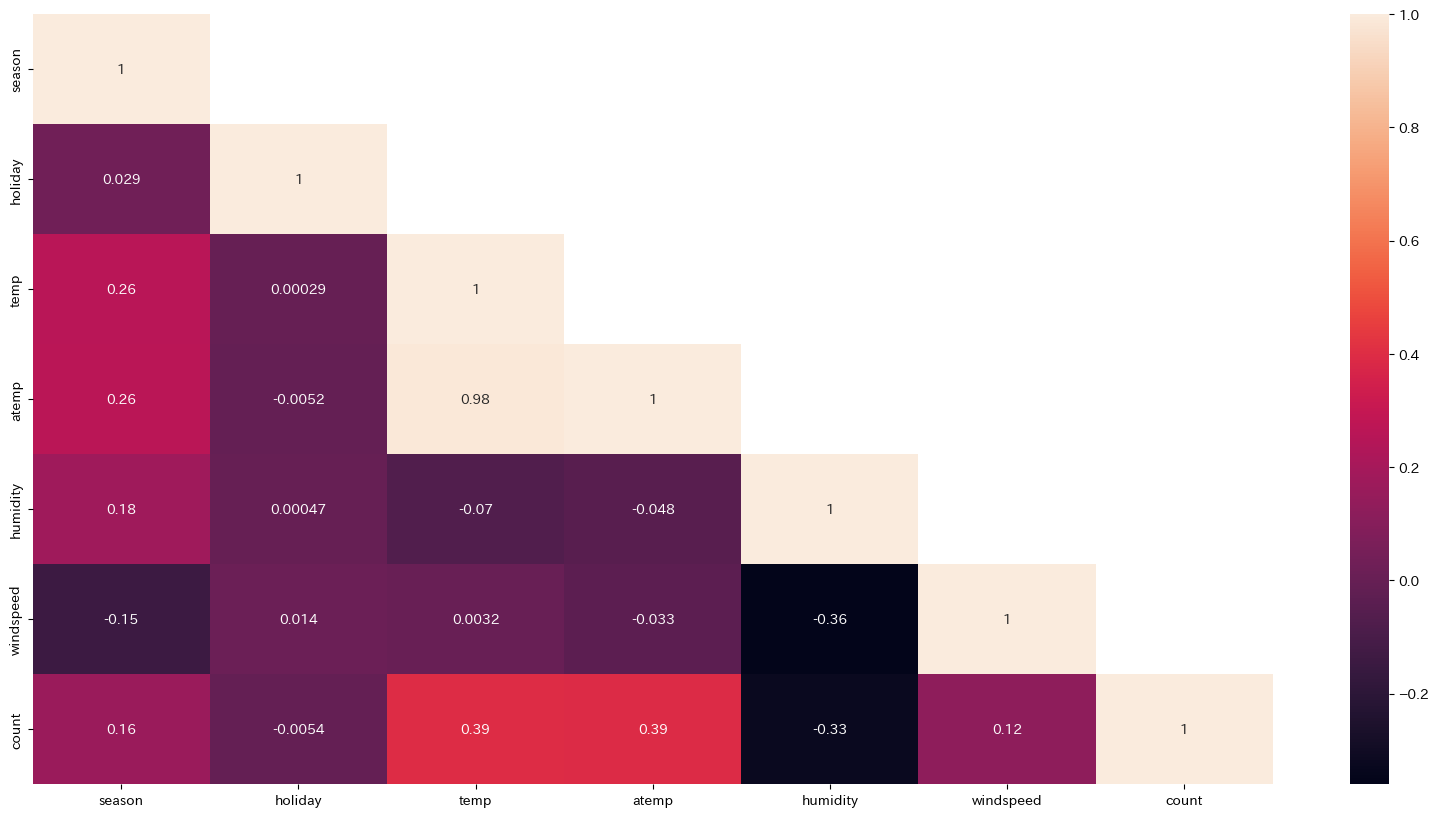

In [39]:
def correlation_heatmap(corr):
    mask = np.array(corr)
    mask[np.tril_indices_from(mask)] = False
    fig,ax= plt.subplots()
    fig.set_size_inches(20,10)
    sns.heatmap(corr, annot=True, mask=mask)

corr = train[['season', 'holiday','temp', 'atemp','humidity', 'windspeed', 'count']].corr()
correlation_heatmap(corr)

### データの可視化
- 機械学習手法が使いやすいようにできるだけ、正規分布に近い形にしたい
- 下図のcountの分布とQQプロットを見ると、通常時はかなり正規分布とずれている
- countを対数変換すると、正規分布には近づくことも見て取れる
    - ただ、まだ正規分布とは言いがたい

/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/888180650.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train["count"],ax=axes[0][0])
/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/888180650.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(train["

((array([-3.83154229, -3.60754977, -3.48462983, ...,  3.48462983,
          3.60754977,  3.83154229]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.87626461, 6.87832647,
         6.88550967])),
 (1.364739645924417, 4.591363690454027, 0.9611793780126949))

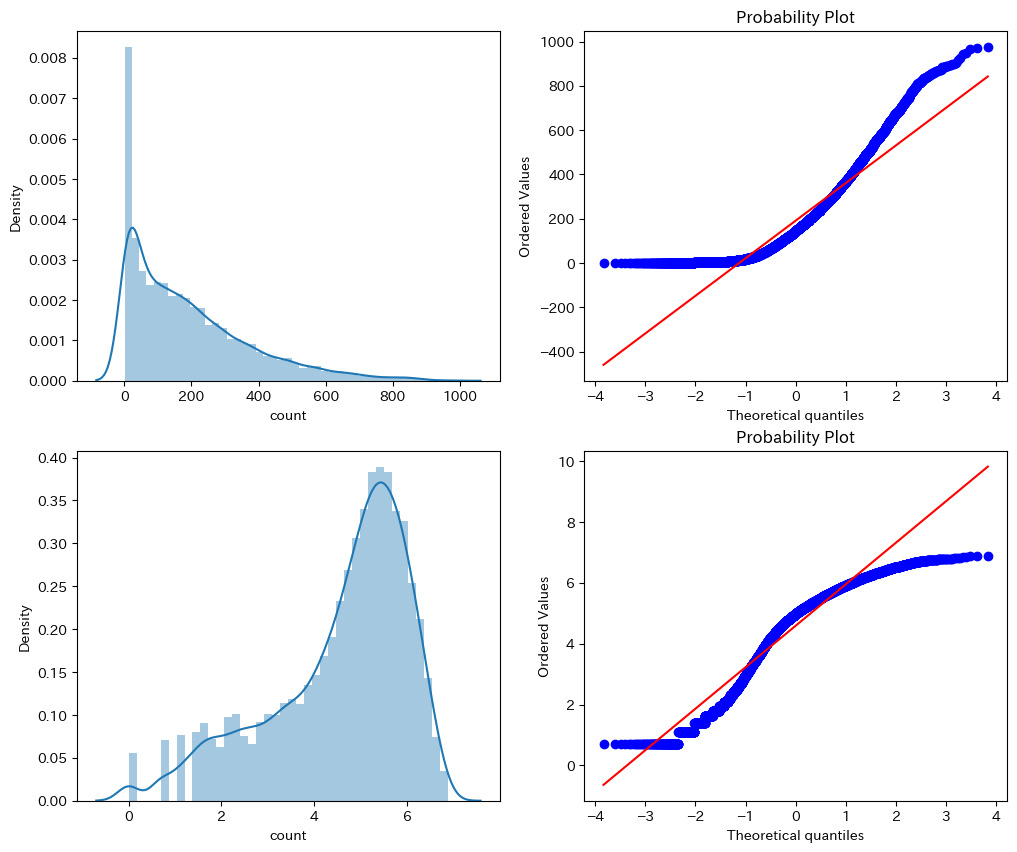

In [40]:
from scipy import stats

fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(train["count"],ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(train["count"]),ax=axes[1][0])
stats.probplot(np.log1p(train["count"]), dist='norm', fit=True, plot=axes[1][1])

### 月別、季節別、時間別、平日別、利用者別でカウントの可視化
- 登録の有無にかかわらず、午前10時から午後4時の間にレンタサイクルを利用する人が多い
- 未登録者は週末の午前10時～午後3時頃にレンタサイクルを利用する傾向がある
    - 平日は通学・通勤など？
    - 週末はレジャー目的？
- 登録者は平日、午前7時～8時、午後5時～6時のレンタサイクルのピークになっている
    - 通勤通学によるものだと考えられる

/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/2260910101.py:12: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/2260910101.py:16: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
/var/folders/q2/v_fyjc515vz9gvp8f8znchk80000gn/T/ipykernel_5469/2260910101.py:21: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0.

  sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)


[Text(0.5, 0, 'Hour Of The Day'),
 Text(0, 0.5, 'Users Count'),
 Text(0.5, 1.0, '利用者ごとの時間別カウント（平均）'),
 None]

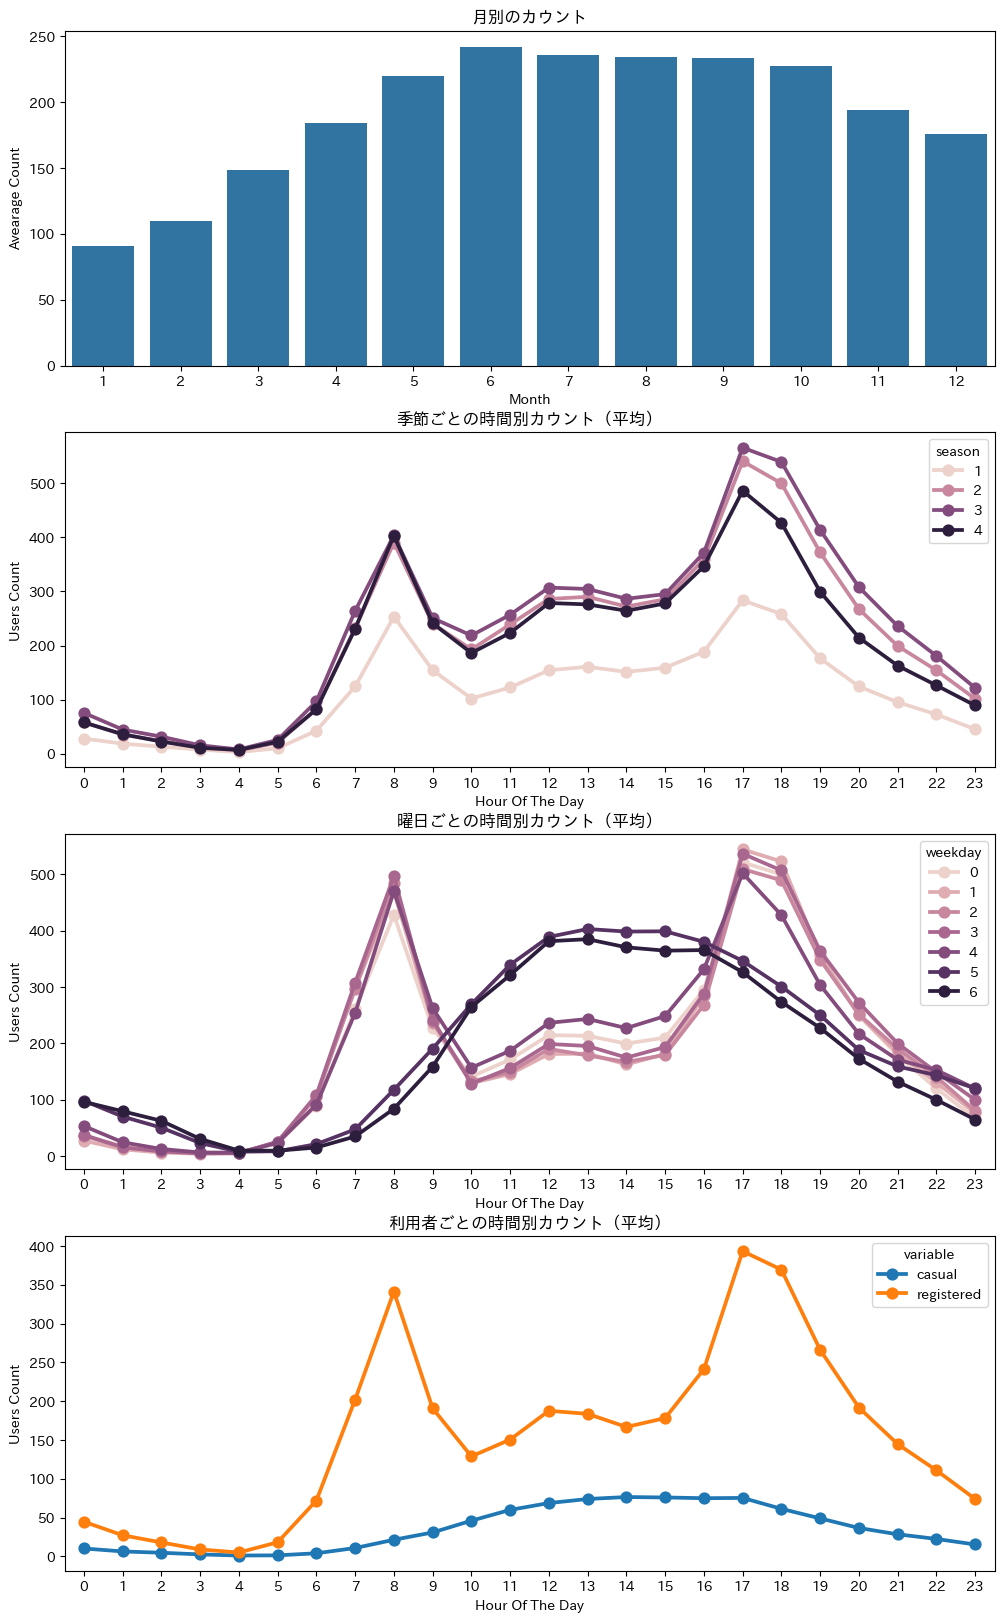

In [42]:
fig,(ax1,ax2,ax3,ax4)= plt.subplots(nrows=4)
fig.set_size_inches(12,20)
sortOrder = [str(i) for i in range(1,13)]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1,order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="月別のカウント")

hourAggregated = pd.DataFrame(train.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"], data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="季節ごとの時間別カウント（平均）",label='big')

hourAggregated = pd.DataFrame(train.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"],hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="曜日ごとの時間別カウント（平均）",label='big')

hourTransformed = pd.melt(train[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = pd.DataFrame(hourTransformed.groupby(["hour","variable"],sort=True)["value"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated, join=True,ax=ax4)
ax4.set(xlabel='Hour Of The Day', ylabel='Users Count',title="利用者ごとの時間別カウント（平均）",label='big')

## 2. モデルの構築
- 性能の評価指標はRMSLEを使用する
    - 実際より少なく予測した場合に大きなペナルティを与える
    - 自転車の需要予測を少なく予測してしまうと、自転車の台数が足りなくなってしまう可能性がある。それは避けたいから、RMSLEを使用する。
- モデル
    - ランダムフォレスト
    - XGBoost

In [43]:
def rmsle(y_real, y_pre):
    log1 = np.log1p(y_real)
    log2 = np.log1p(y_pre)
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [47]:
print(train.columns)
print(test.columns)

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'week', 'weekday', 'count_log'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'year', 'month', 'day', 'hour',
       'week', 'weekday'],
      dtype='object')


In [52]:
train = train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())]

In [55]:
drop_columns = ['count', 'count_log', 'casual', 'registered', 'datetime']
X_train = train.drop(drop_columns, axis = 1).values
X_test = test.drop(['datetime'], axis = 1).values

yLog = train['count_log'].values
x_date = test['datetime'].values

In [56]:
print(X_train.shape)
print(X_test.shape)

(10739, 14)
(6493, 14)


In [57]:
rf_columns = [
    'weather', 'temp', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'week',
]
gb_columns =[
    'weather', 'temp', 'humidity', 'windspeed',
    'workingday', 'season', 'holiday',
    'hour', 'weekday', 'year'
]

In [58]:
rf_x_train = train[rf_columns].values
rf_x_test = test[rf_columns].values

gb_x_train = train[gb_columns].values
gb_x_test = test[gb_columns].values

y_casual = train['casual'].apply(lambda x: np.log1p(x)).values
y_registered = train['registered'].apply(lambda x: np.log1p(x)).values
y = train['count'].apply(lambda x: np.log1p(x)).values

X_date = test['datetime'].values

In [60]:
from sklearn.model_selection import train_test_split

drop_columns = ['count', 'count_log', 'casual', 'registered', 'datetime']
X_train = train.drop(drop_columns, axis = 1).values
xd_train, xd_test, yd_train, yd_test = train_test_split(X_train,y,random_state=0)

In [61]:
#XGBoost
xgb_model = xgb.XGBRegressor()

def XGB_model():
    xgb_parameters = {'random_state': [42],
                'n_estimators': [300, 370, 400],
                'max_depth': [4, 5],
                'learning_rate': [0.1]}

    rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better = False)

    gs = GridSearchCV(estimator = xgb_model, param_grid = xgb_parameters, scoring = rmsle_scorer, cv = 5)
    gs.fit(xd_train, yd_train)
    print('Best params for XGBoost model are: ', gs.best_params_)

    test_pred = gs.predict(xd_test)

    score = rmsle(yd_test,test_pred)
    return score

In [62]:
#RandomForest
from sklearn.ensemble import RandomForestRegressor

def RandomForest_model():
    params = {'n_estimators': 1000,
            'max_depth': 15,
            'random_state': 0,
            'min_samples_split' : 2,
            'n_jobs': -1}

    rfr = RandomForestRegressor(**params)
    rfr.fit(xd_train, yd_train)
    test_pred = rfr.predict(xd_test)

    score = rmsle(yd_test,test_pred)
    return score

In [68]:
from sklearn.ensemble import GradientBoostingRegressor

def GradientBoosting_model():
    gbr = GradientBoostingRegressor(n_estimators = 1000,
                                    max_depth = 5,
                                    random_state = 0)
    gbr.fit(xd_train,yd_train)
    test_pred = gbr.predict(xd_test)
    score = rmsle(yd_test,test_pred)
    return score

In [63]:
# RMSLEの値
print("XGBoost:      ",XGB_model())
print("RandomForest: ",RandomForest_model())

Best params for XGBoost model are:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 370, 'random_state': 42}
XGBoost:       0.07925954203361751
RandomForest:  0.08178419209052033


In [69]:
print("GradientBoost: ",GradientBoosting_model())

GradientBoost:  0.08104491746590935


## 3. 予測値の出力
- casualとregisteredのパターンは異なるため、それぞれにモデルを当てはめて、最後に合計して、countの予測値を出力する


In [64]:
# XGBoostの予測値
xgb_params = {'random_state': 42,
            'n_estimators': 370,
            'max_depth': 5,
            'learning_rate': 0.1}

XGB1 = xgb.XGBRegressor(**xgb_params)
XGB1.fit(gb_x_train,y_casual)
print("casualのmodel score:",XGB1.score(gb_x_train,y_casual))

XGB2 = xgb.XGBRegressor(**xgb_params)
XGB2.fit(gb_x_train,y_registered)
print("registeredのmodel score:",XGB2.score(gb_x_train,y_registered))

XGB3 = xgb.XGBRegressor(**xgb_params)
XGB3.fit(gb_x_train,y)
print("countのmodel score:",XGB3.score(gb_x_train,y))

casualのmodel score: 0.9340400972212706
registeredのmodel score: 0.9756408206877112
countのmodel score: 0.9761169112630523


### 特徴量ごとにモデルの寄与度を算出する

<Figure size 1500x1200 with 0 Axes>

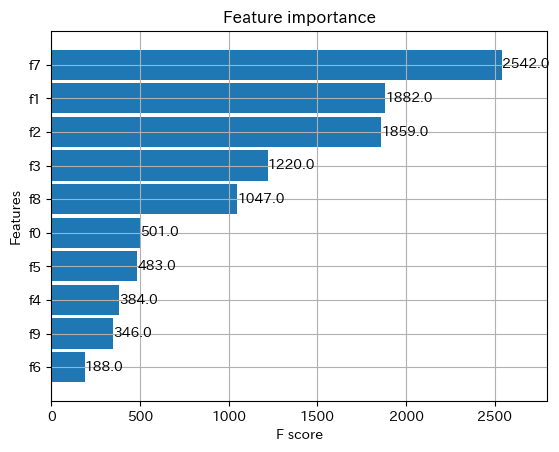

In [65]:
from xgboost import plot_importance

fig = plt.figure(figsize=(15,12))
fig = plot_importance(XGB3, height=0.9, max_num_features = 25)
plt.show()

In [67]:
# random forestの予測値
params = {'n_estimators': 1000,
        'max_depth': 15,
        'random_state': 0,
        'min_samples_split' : 2,
        'n_jobs': -1}

rfr = RandomForestRegressor(**params)
rfr.fit(X_train, yLog)
print(rfr.score(X_train, yLog))

0.9914606892761947


In [71]:
# gradient boosting
from sklearn.ensemble import GradientBoostingRegressor

gbr_params = {'n_estimators': 150,
        'max_depth': 5,
        'random_state': 0,
        'min_samples_leaf' : 10,
        'learning_rate': 0.1,
        'subsample': 0.7,
        'loss': 'squared_error'}

GBR1 = GradientBoostingRegressor(**gbr_params)
GBR1.fit(gb_x_train,y_casual)
print("casualのmodel score:",GBR1.score(gb_x_train,y_casual))

GBR2 = GradientBoostingRegressor(**gbr_params)
GBR2.fit(gb_x_train,y_registered)
print("registeredのmodel score:",GBR2.score(gb_x_train,y_registered))

GBR3 = GradientBoostingRegressor(**gbr_params)
GBR3.fit(gb_x_train,y)
print("countのmodel score:",GBR3.score(gb_x_train,y))

casualのmodel score: 0.9187055763788984
registeredのmodel score: 0.9675287302675345
countのmodel score: 0.9674597499934752


In [73]:
def prediction(x_test, models):
    prediction = []
    for model in models:
        pre = model.predict(x_test)
        pre = np.expm1(pre)
        prediction.append(pre)
    return sum(prediction)

pred_xgb = prediction(gb_x_test, models=[XGB1, XGB2])
pred_gbr = prediction(gb_x_test, models=[GBR1, GBR2])

### アンサンブルして、出力

In [74]:
prediction = (0.6 * pred_xgb) + (0.4 * pred_gbr)

In [75]:
submit = pd.DataFrame({'datetime':x_date,'count':prediction})
submit.to_csv('../submit/submisssion.csv',index=False)